# Sesión 3 — Visualización de datos como herramienta de análisis  
## Notebook lineal para el seguimiento de la clase

Este notebook está pensado para **seguir en clase** (paso a paso, lineal).  
Recorreremos el flujo:

1. Carga + verificaciones mínimas  
2. Univariante (diagnóstico)  
3. Bivariante (relaciones)  
4. Mini-pipeline de EDA (visión global → exploración dirigida)  
5. Preparación mínima para modelado (pipeline)  
6. Modelo baseline (Regresión Logística)  
7. Evaluación (matriz de confusión, accuracy, precision, recall, F1, ROC-AUC)  
8. Umbral de decisión (trade-offs)  
9. Validación cruzada (estabilidad)

> Nota: no buscamos “ganar”; buscamos **entender** y crear una referencia honesta.


## 0) Setup del entorno

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Opcional (si está instalado). Si no, el notebook sigue funcionando sin seaborn.
try:
    import seaborn as sns
except Exception:
    sns = None

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


## 1) Cargar el dataset (CSV) y entender qué es `df`

Coloca el archivo **`datos_ejercicios_sesion3.csv`** en la misma carpeta que este notebook.  
Si está en otra carpeta, ajusta la ruta (por ejemplo: `data/datos_ejercicios_sesion3.csv`).


In [3]:
DATA_PATH = "datos_sesion_3.csv"

df = pd.read_csv(DATA_PATH)
df.shape

(3015, 20)

### 1.1 Vista rápida

In [5]:
df["device_type"]

,device_type
0,mobile
1,mobile
2,desktop
3,desktop
4,desktop
...,...
3010,mobile
3011,tablet
3012,mobile
3013,mobile


In [6]:
df.head(5)

,customer_id,signup_date,last_login,country,region_code,device_type,referral_source,plan_level,plan_name,tenure_months,monthly_fee,num_logins_30d,avg_session_minutes,support_tickets_90d,payment_method,auto_pay,income_annual,satisfaction_score,churned,data_source
0,100861,2024-06-13,2024-08-11 00:00:00,ES,203,mobile,email,1,Basic,30,13.96,5,11.34,0,card,1,NaN,NaN,0,bootcamp_synthetic_v1
1,101247,2023-02-10,2023-11-28 00:00:00,ES,201,mobile,organic,1,Basic,21,16.89,11,5.77,1,paypal,0,12123.81,5,0,bootcamp_synthetic_v1
2,100973,2023-08-03,2023-08-12 00:00:00,ES,102,desktop,organic,2,Standard,30,19.76,15,14.17,0,card,1,NaN,4,0,bootcamp_synthetic_v1
3,101488,2022-09-09,2023-03-18 00:00:00,ES,101,desktop,organic,1,Basic,2,9.26,3,11.25,1,paypal,1,52597.84,5,0,bootcamp_synthetic_v1
4,102061,2022-05-25,2022-11-30 00:00:00,FR,201,desktop,ads,2,Standard,21,17.83,6,13.33,1,card,0,45381.26,4,0,bootcamp_synthetic_v1


### 1.2 Columnas

In [7]:
df.columns

Index(['customer_id', 'signup_date', 'last_login', 'country', 'region_code', 'device_type', 'referral_source',
       'plan_level', 'plan_name', 'tenure_months', 'monthly_fee', 'num_logins_30d', 'avg_session_minutes',
       'support_tickets_90d', 'payment_method', 'auto_pay', 'income_annual', 'satisfaction_score', 'churned',
       'data_source'],
      dtype='object')

### 1.3 Tipos inferidos (`dtypes`)

In [8]:
df.dtypes

,0
customer_id,int64
signup_date,object
last_login,object
country,object
region_code,int64
device_type,object
referral_source,object
plan_level,int64
plan_name,object
tenure_months,int64


### 1.4 Missing values (visión global)

In [12]:
df.isna().sum().sort_values(ascending=False).head(5)

,0
satisfaction_score,639
income_annual,356
customer_id,0
signup_date,0
country,0


## 2) Análisis univariante (diagnóstico)

Objetivo: **entender una variable a la vez** antes de hablar de relaciones o modelos.

Regla: aquí **detectamos y documentamos**, pero no “arreglamos” todo aún.


### 2.1 Resumen estadístico rápido (`describe`)

In [15]:
col = "num_logins_30d"  # ajusta si tu dataset usa otro nombre
df[col].describe()

,num_logins_30d
count,3015.000000
mean,11.070315
std,4.884842
min,0.000000
25%,7.000000
50%,10.000000
75%,14.000000
max,32.000000


### 2.2 Histograma (distribución)

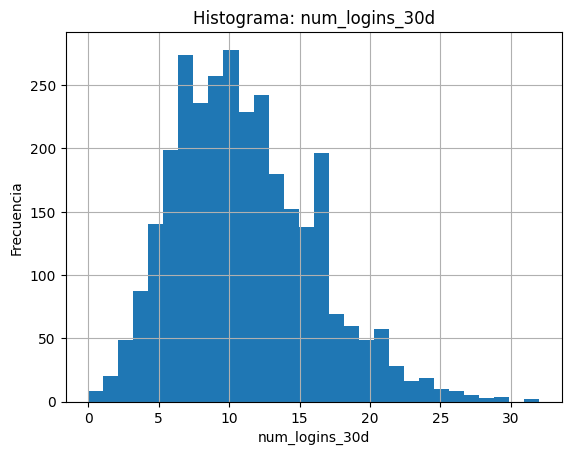

In [16]:
col = "num_logins_30d"

df[col].hist(bins=30)
plt.xlabel(col)
plt.ylabel("Frecuencia")
plt.title(f"Histograma: {col}")
plt.show()

### 2.3 Conteos (variables discretas) con `value_counts()`

In [17]:
col = "support_tickets_90d"
df[col].value_counts().sort_index().head(30)

,count
support_tickets_90d,
0,1015
1,1034
2,628
3,241
4,71
5,20
6,6


### 2.4 Categóricas: frecuencias y proporciones

In [19]:
cat = "country"  # ajusta si tu dataset usa otro nombre
df[cat].value_counts().head(10)

,count
country,
ES,1118
FR,455
IT,431
GB,427
DE,373
PT,211


In [22]:
df[cat].value_counts(normalize=True) * 100

,proportion
country,
ES,37.081260
FR,15.091211
IT,14.295191
GB,14.162521
DE,12.371476
PT,6.998342


### 2.5 Missing (una variable concreta)

In [23]:
col = "income_annual"
df[col].isna().sum()

np.int64(356)

## 3) Relaciones entre variables (bivariante)

Objetivo: formular **hipótesis verificables**.  
Regla: relación ≠ causalidad.


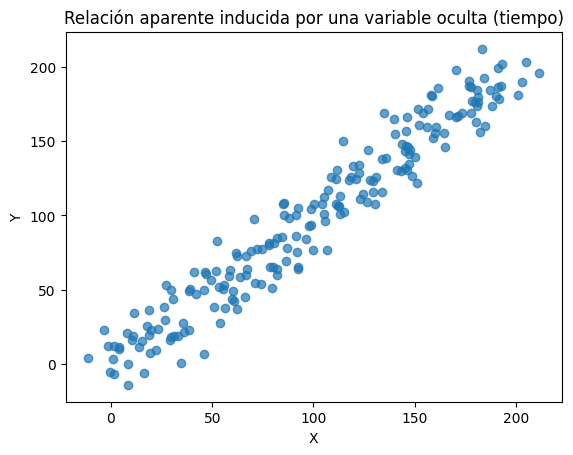

In [24]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(0)
t = np.arange(200)
x = t + rng.normal(0,10, size=t.size)
y = t + rng.normal(0,10, size=t.size)
plt.scatter(x, y, alpha=0.7)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Relación aparente inducida por una variable oculta (tiempo)")
plt.show()

### 3.1 Scatter plot (dos numéricas)

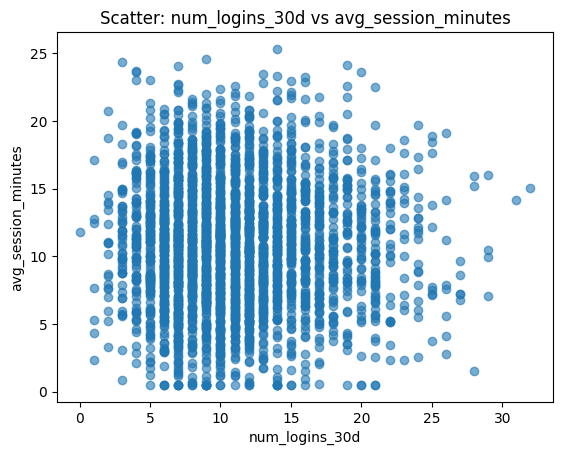

In [25]:
xcol = "num_logins_30d"
ycol = "avg_session_minutes"

plt.scatter(df[xcol], df[ycol], alpha=0.6)
plt.xlabel(xcol)
plt.ylabel(ycol)
plt.title(f"Scatter: {xcol} vs {ycol}")
plt.show()

### 3.2 Lectura guiada de un scatter plot
Responde, por orden:
1) tendencia global, 2) lineal / no lineal, 3) ruido, 4) outliers, 5) subgrupos.


### 3.3 Variable objetivo: comparar por grupos (si existe `churned`)

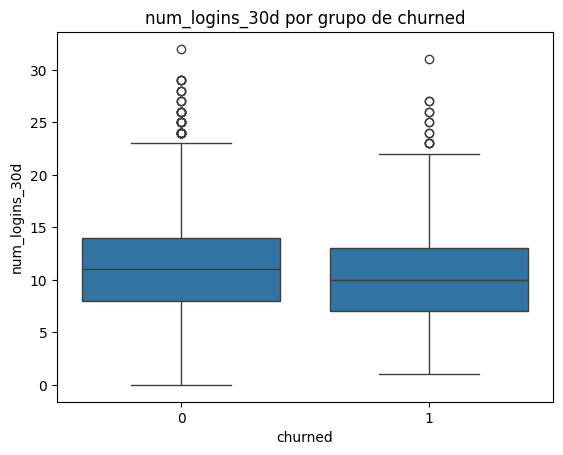

In [27]:
target = "churned"
feature = "num_logins_30d"

if target in df.columns:
    if sns is None:
        print("Seaborn no está disponible. Boxplot simple con Matplotlib.")
        grp0 = df[df[target] == 0][feature].dropna()
        grp1 = df[df[target] == 1][feature].dropna()
        plt.boxplot([grp0, grp1], labels=["0", "1"])
        plt.xlabel(target)
        plt.ylabel(feature)
        plt.title(f"{feature} por grupo de {target}")
        plt.show()
    else:
        sns.boxplot(data=df, x=target, y=feature)
        plt.title(f"{feature} por grupo de {target}")
        plt.show()
else:
    print("No existe la columna 'churned' en este dataset.")

Text(0, 0.5, 'Y')

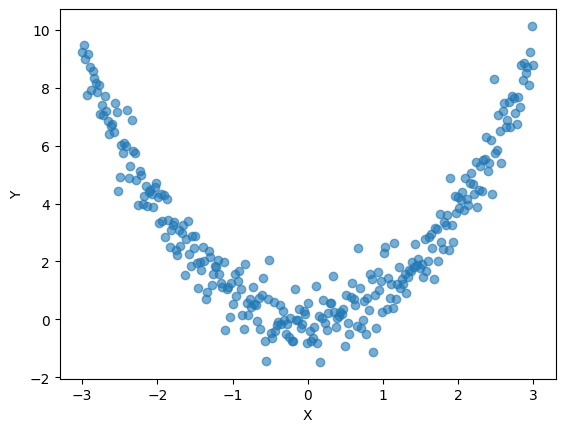

In [28]:
import numpy as np
rng = np.random.default_rng(1)
x = np.linspace(-3,3,300)
y = x**2 + rng.normal(0,0.7, size=x.size)
plt.scatter(x, y, alpha=0.6)
plt.xlabel("X")
plt.ylabel("Y")

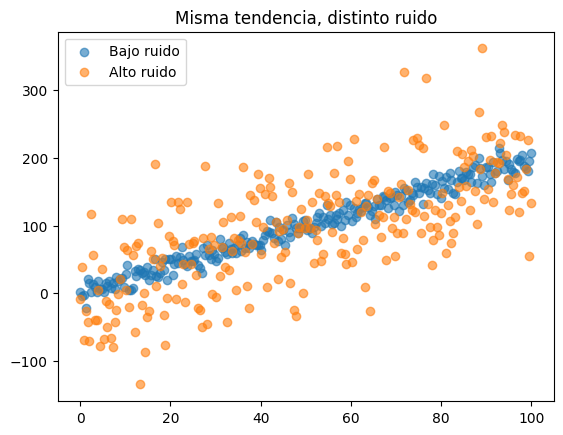

In [29]:
rng = np.random.default_rng(2)
x = np.linspace(0,100,250)
y_low =2 * x + rng.normal(0,10, size=x.size)
y_high =2 * x + rng.normal(0,60, size=x.size)
plt.scatter(x, y_low, alpha=0.6, label="Bajo ruido")
plt.scatter(x, y_high, alpha=0.6, label="Alto ruido")
plt.legend()
plt.title("Misma tendencia, distinto ruido")
plt.show()

### 3.4 Correlación como mapa (solo numéricas)

In [34]:
df_num = df.select_dtypes(include="number")
corr = df_num.corr(numeric_only=True)
corr.head()

,customer_id,region_code,plan_level,tenure_months,monthly_fee,num_logins_30d,avg_session_minutes,support_tickets_90d,auto_pay,income_annual,churned
customer_id,1.000000,0.014377,-0.016548,-0.010446,-0.020319,-0.018563,-0.023241,-0.014457,0.007728,0.023330,0.030243
region_code,0.014377,1.000000,0.000124,0.002633,0.008611,-0.000977,0.004969,-0.009670,-0.022702,-0.029630,0.007376
plan_level,-0.016548,0.000124,1.000000,0.018690,0.137437,0.736318,-0.007375,-0.260695,0.027916,-0.028021,-0.071252
tenure_months,-0.010446,0.002633,0.018690,1.000000,-0.045813,0.031867,0.002810,0.029190,-0.017692,0.001658,-0.076158
monthly_fee,-0.020319,0.008611,0.137437,-0.045813,1.000000,0.105937,-0.022648,-0.052836,0.019093,-0.029339,-0.019185


In [35]:
corr.columns

Index(['customer_id', 'region_code', 'plan_level', 'tenure_months', 'monthly_fee', 'num_logins_30d',
       'avg_session_minutes', 'support_tickets_90d', 'auto_pay', 'income_annual', 'churned'],
      dtype='object')

### 3.5 Correlación con el objetivo (si existe) — solo para priorizar exploración

In [36]:
if "churned" in corr.columns:
    corr["churned"].drop("churned").sort_values(key=lambda s: s.abs(), ascending=False).head(12)
else:
    print("No existe 'churned' numérico para correlación con objetivo.")

In [38]:
hipotesis = [
"Menor uso (logins) podría asociarse a mayor churn → verificar por grupos",
"Más tickets de soporte podrían asociarse a churn → comprobar ruido",
"Plan y cuota mensual podrían ser redundantes → revisar outliers",
]
for i, h in enumerate(hipotesis,1):
  print(f"{i}.{h}")

1.Menor uso (logins) podría asociarse a mayor churn → verificar por grupos
2.Más tickets de soporte podrían asociarse a churn → comprobar ruido
3.Plan y cuota mensual podrían ser redundantes → revisar outliers


## 4) Pipeline mínimo de EDA aplicado (visión global → exploración dirigida)

Esquema:
1) preparación mínima defensiva  
2) visión global (relaciones)  
3) exploración dirigida (confirmar forma/outliers)  
4) univariante focalizado  
5) comparación por grupos (si hay objetivo)


### 4.1 Preparación mínima defensiva (ejemplos típicos)

In [39]:
df_eda = df.copy()

# (A) Fechas como texto → datetime (si existen)
for c in ["signup_date", "last_login"]:
    if c in df_eda.columns:
        df_eda[c] = pd.to_datetime(df_eda[c], errors="coerce")

# (B) Ejemplos de sentinelas (si existen esas columnas y valores)
if "income_annual" in df_eda.columns:
    df_eda.loc[df_eda["income_annual"] == -1, "income_annual"] = np.nan

if "monthly_fee" in df_eda.columns:
    df_eda.loc[df_eda["monthly_fee"] == 999, "monthly_fee"] = np.nan

df_eda.isna().sum().sort_values(ascending=False).head(12)

,0
satisfaction_score,639
income_annual,364
monthly_fee,6
customer_id,0
country,0
last_login,0
signup_date,0
region_code,0
plan_level,0
plan_name,0


In [44]:
df_eda.dtypes

,0
customer_id,int64
signup_date,datetime64[ns]
last_login,datetime64[ns]
country,object
region_code,int64
device_type,object
referral_source,object
plan_level,int64
plan_name,object
tenure_months,int64


### 4.2 Visión global: heatmap de correlación (si seaborn está disponible)

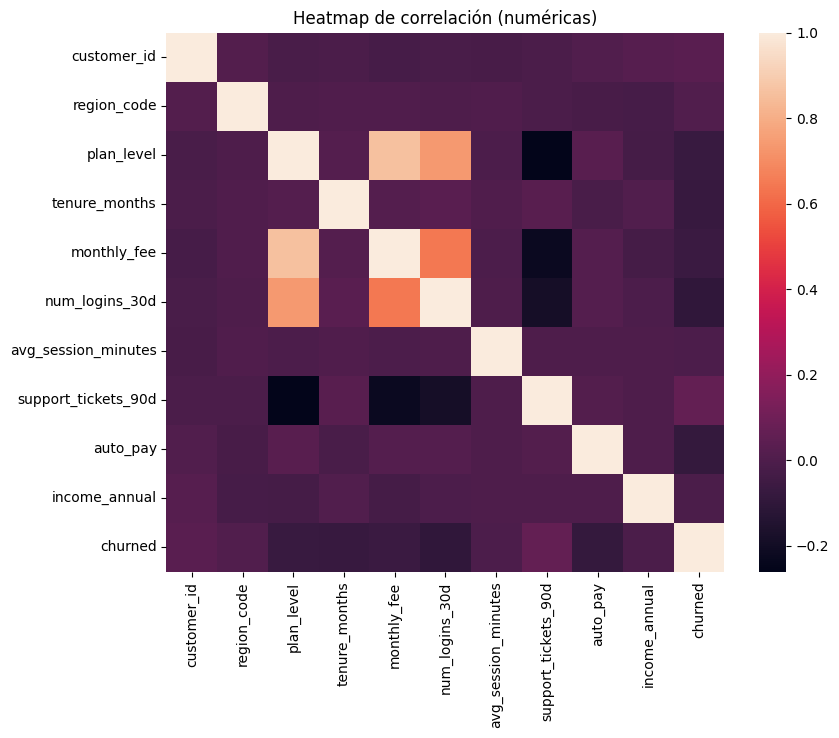

In [45]:
df_num = df_eda.select_dtypes(include="number")
corr = df_num.corr(numeric_only=True)

if sns is None:
    print("Seaborn no está disponible. Se muestra la matriz 'corr'.")
    corr
else:
    plt.figure(figsize=(9, 7))
    sns.heatmap(corr, annot=False)
    plt.title("Heatmap de correlación (numéricas)")
    plt.show()

### 4.3 Exploración dirigida: escoger 2–3 pares y confirmarlos con scatter

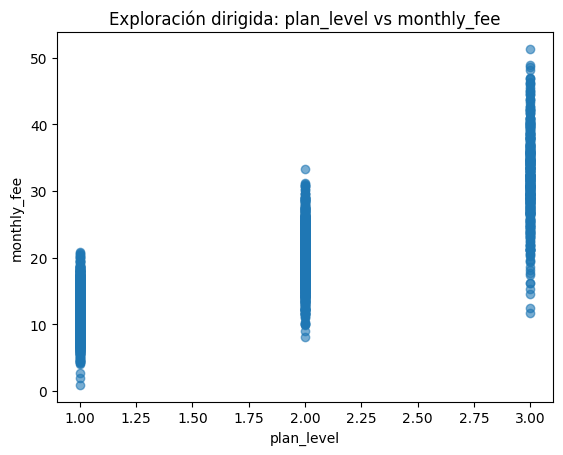

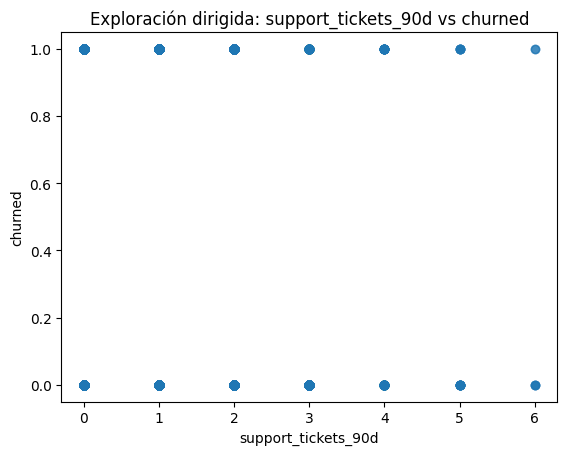

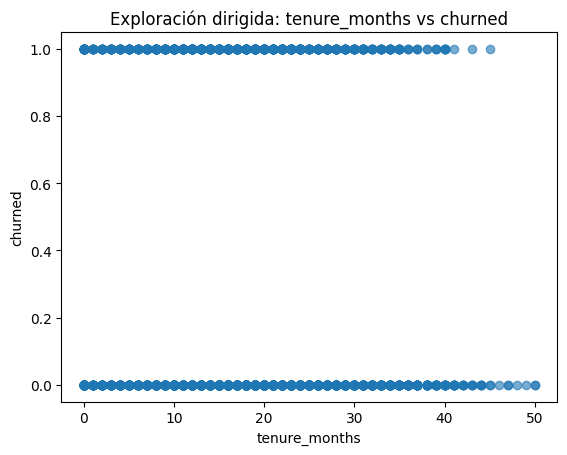

In [46]:
pairs = [
    ("plan_level", "monthly_fee"),
    ("support_tickets_90d", "churned"),
    ("tenure_months", "churned")
]

for a, b in pairs:
    if a in df_eda.columns and b in df_eda.columns:
        plt.scatter(df_eda[a], df_eda[b], alpha=0.6)
        plt.xlabel(a)
        plt.ylabel(b)
        plt.title(f"Exploración dirigida: {a} vs {b}")
        plt.show()
    else:
        print(f"Par omitido (no existe columna): {a}, {b}")

## 5) Preparación mínima para modelado (pipeline reproducible)

Objetivo:
- imputar missing  
- codificar categóricas  
- escalar numéricas (por coherencia)  
- evitar *data leakage* usando pipeline

> No “limpiamos todo”; hacemos lo mínimo para entrenar un baseline.


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

### 5.1 Separar X / y (asumimos `churned` como objetivo)

In [48]:
target = "churned"
if target not in df_eda.columns:
    raise ValueError("Este notebook asume una columna objetivo llamada 'churned'. Ajusta 'target' si tu dataset usa otro nombre.")

X = df_eda.drop(columns=[target])
y = df_eda[target]

X.shape, y.shape

((3015, 19), (3015,))

### 5.2 Detectar columnas numéricas y categóricas

In [49]:
num_cols = X.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

Numéricas: ['customer_id', 'region_code', 'plan_level', 'tenure_months', 'monthly_fee', 'num_logins_30d', 'avg_session_minutes', 'support_tickets_90d', 'auto_pay', 'income_annual']
Categóricas: ['country', 'device_type', 'referral_source', 'plan_name', 'payment_method', 'satisfaction_score', 'data_source']


### 5.3 Definir preprocesado (imputación + escalado + one-hot)

In [50]:
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ],
    remainder="drop"
)

preprocess

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['customer_id', 'region_code', 'plan_level',
                                  'tenure_months', 'monthly_fee',
                                  'num_logins_30d', 'avg_session_minutes',
                                  'support_tickets_90d', 'auto_pay',
                                  'income_annual']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['country', 'device_type', 'referral_source',
                                  'plan_name', 'payment_method',
                                  'satisfaction_score', 'data_source'])])

### 5.4 Split train/test

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((2261, 19), (754, 19))

## 6) Modelo baseline: Regresión Logística

Un baseline:
- simple
- interpretable
- rápido
- referencia honesta


In [52]:
from sklearn.linear_model import LogisticRegression

### 6.1 Pipeline completo (preprocess + model)

In [53]:
clf = LogisticRegression(max_iter=2000)

pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", clf)
])

pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['customer_id', 'region_code',
                                                   'plan_level',
                                                   'tenure_months',
                                                   'monthly_fee',
                                                   'num_logins_30d',
                                                   'avg_session_minutes',
                                                   'support_tickets_90d',
                                                   'auto_pay',
                                                   'income_annual']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country', 'device_type',
                                                   'referral_source',
                                                   'plan_name',
                                                   'payment_method',
                                                   'satisfaction_score',
                                                   'data_source'])])),
                ('model', LogisticRegression(max_iter=2000))])

### 6.2 Entrenar

In [54]:
pipeline.fit(X_train, y_train)
"OK"

'OK'

### 6.3 Probabilidades y predicción (umbral 0.5)

In [55]:
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

y_pred_proba[:5], y_pred[:5]

(array([0.2082869 , 0.26422197, 0.21441884, 0.1881305 , 0.31382974]),
 array([0, 0, 0, 0, 0]))

## 7) Evaluación: matriz de confusión + métricas

Regla: antes de métricas, mira la **matriz de confusión**.


In [56]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)

### 7.1 Matriz de confusión

In [57]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[574,   5],
       [174,   1]])

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format="d")
plt.title("Matriz de confusión (umbral 0.5)")
plt.show()

### 7.2 Accuracy, Precision, Recall, F1

In [58]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

acc, prec, rec, f1

(0.7625994694960212,
 0.16666666666666666,
 0.005714285714285714,
 0.011049723756906077)

### 7.3 Curva ROC y ROC-AUC

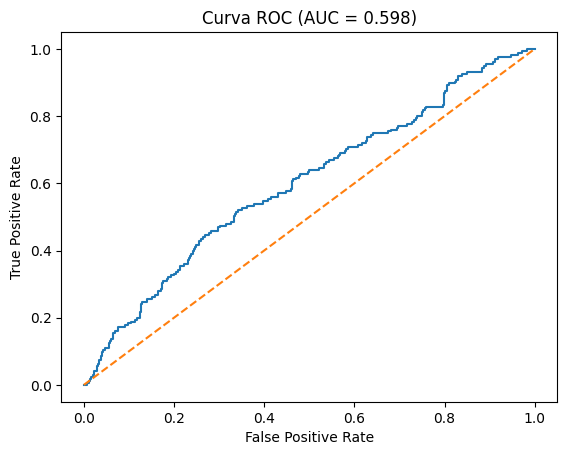

np.float64(0.5983518381445843)

In [59]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Curva ROC (AUC = {auc:.3f})")
plt.show()

auc

## 8) Umbral de decisión: trade-offs operativos

Cambiar el umbral **no cambia el modelo**. Cambia cómo lo usas.


In [60]:
def eval_threshold(y_true, y_proba, threshold):
    y_pred_t = (y_proba >= threshold).astype(int)
    cm_t = confusion_matrix(y_true, y_pred_t)
    p = precision_score(y_true, y_pred_t, zero_division=0)
    r = recall_score(y_true, y_pred_t, zero_division=0)
    f1t = f1_score(y_true, y_pred_t, zero_division=0)
    return cm_t, p, r, f1t

for t in [0.3, 0.5, 0.7]:
    cm_t, p, r, f1t = eval_threshold(y_test, y_pred_proba, t)
    print(f"Umbral: {t}")
    print("Matriz de confusión:\n", cm_t)
    print(f"Precision: {p:.3f} | Recall: {r:.3f} | F1: {f1t:.3f}")
    print("-" * 50)

Umbral: 0.3
Matriz de confusión:
 [[477 102]
 [121  54]]
Precision: 0.346 | Recall: 0.309 | F1: 0.326
--------------------------------------------------
Umbral: 0.5
Matriz de confusión:
 [[574   5]
 [174   1]]
Precision: 0.167 | Recall: 0.006 | F1: 0.011
--------------------------------------------------
Umbral: 0.7
Matriz de confusión:
 [[579   0]
 [175   0]]
Precision: 0.000 | Recall: 0.000 | F1: 0.000
--------------------------------------------------


## 9) Validación cruzada: medir estabilidad

Regla metodológica: CV se hace sobre **entrenamiento** (no uses el test para ajustar).


In [61]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [62]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc")

scores, scores.mean(), scores.std()

(array([0.59621554, 0.57260876, 0.56541787, 0.62385069, 0.56945245]),
 np.float64(0.5855090611090829),
 np.float64(0.02196632950169997))

## 10) Cierre

Si este notebook ha ido bien, ahora deberías poder:

- cargar un CSV y verificarlo
- hacer un diagnóstico univariante razonado
- explorar relaciones sin caer en causalidad automática
- construir un pipeline mínimo reproducible
- entrenar y evaluar un baseline
- entender trade-offs de umbral
- estimar estabilidad con validación cruzada

Este notebook es **de clase**. Los ejercicios deben ser distintos.
